In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [17]:
#бинарные
def square_binary(img):
    img = np.array(img)
    return np.sum(img)

def closure_binary(X, B):
    return cv2.erode(cv2.dilate(X, B, borderValue=0), B, borderValue=0)

def laundry_binary(X, B):
    return cv2.dilate(cv2.erode(X, B, borderValue=0), B, borderValue=0)

#полутоновые
def get_tone(X, t):
    X_ = X.copy()
    X_[np.where(X < t)] = 0
    X_[np.where(X >= t)] = 1
    return X_

def erode_halftone(X, B):
    return np.array([t * cv2.erode(get_tone(X, t), B, borderValue=0) for t in range(1, 256)], dtype=np.uint8).max(
        axis=0)

def dilate_halftone(X, B):
    return np.array([t * cv2.dilate(get_tone(X, t), B, borderValue=0) for t in range(1, 256)], dtype='uint8').max(
        axis=0)

def square_halftone(img):
    return np.sum(img)

def closure_halftone(X, B):
    return erode_halftone(dilate_halftone(X, B), B)

def laundry_halftone(X, B):
    return dilate_halftone(erode_halftone(X, B), B)

In [22]:
def modiff_B(B, n):
    pad_delta = B.shape[0] // 2
    if n == 0:
        curr_B = np.pad(np.array([[1]], dtype='uint8'), (pad_delta, pad_delta), 'constant',
                        constant_values=(0, 0))
        return curr_B
    curr_B = B
    for i in range(n - 1):
        curr_B = np.pad(curr_B, (pad_delta, pad_delta), 'constant',
                        constant_values=(0, 0))
        curr_B = cv2.dilate(curr_B, B, borderValue=0)
    return curr_B

In [28]:
def getN(X, B):
    n = 0
    curr_B = modiff_B(B, n)
    counter_x = cv2.erode(X, curr_B, borderValue=0)
    while np.sum(counter_x) > 0:
        n += 1
        curr_B = modiff_B(B, n)
        counter_x = cv2.erode(X, curr_B, borderValue=0)
    return n

In [5]:
def minus(left_arr, right_arr):
    right_arr[np.where(right_arr > left_arr)] = 0
    return left_arr - right_arr

In [32]:
def getK(X, B):
    k = 1
    curr_B = B
    prev_x = X
    counter_x = closure_binary(X, curr_B)
    while np.sum(np.abs(prev_x - counter_x)) != 0:
        k += 1
        prev_x = counter_x
        curr_B = modiff_B(B, k)
        counter_x = closure_binary(X, curr_B)
    return k

In [36]:
def get_spectrum_binary(X, B):
    N = getN(X, B)
    K = getK(X, B)
    n_square = {}
    B_0 = modiff_B(B, 0)
    curr_X = minus(laundry_binary(X, B_0), laundry_binary(X, B))
    n_square[0] = square_binary(curr_X)

    for i in range(1, N + 1):
        curr_X = minus(laundry_binary(X, modiff_B(B, i)), laundry_binary(X, modiff_B(B, i + 1)))
        n_square[i] = square_binary(curr_X)

    curr_X = minus(closure_binary(X, B), closure_binary(X, B_0))
    n_square[-1] = square_binary(curr_X)
    for i in range(2, K + 1):
        curr_X = minus(closure_binary(X, modiff_B(B, i)), closure_binary(X, modiff_B(B, i - 1)))
        n_square[-1 * i] = square_binary(curr_X)
    return n_square

In [37]:
B1 = np.array([[1, 1, 1],
               [1, 1, 1],
               [1, 1, 1]], dtype='uint8')
B2 = np.array([[0, 1, 0],
               [1, 1, 1],
               [0, 1, 0]], dtype='uint8')
B3 = np.array([[0, 1, 1, 1, 0],
               [1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1],
               [0, 1, 1, 1, 0]], dtype='uint8')

In [38]:
def print_spectrum(spectrum):
    plt.bar(spectrum.keys(), spectrum.values())
    plt.show()

In [42]:
def getN_halftone(X, B):
    n = 0
    X = X.astype('uint8')
    curr_B = modiff_B(B, n).astype('uint8')
    counter_x = erode_halftone(X, curr_B).astype('uint8')
    while square_halftone(counter_x) > 0:
        n += 1
        curr_B = modiff_B(B, n).astype('uint8')
        counter_x = erode_halftone(X, curr_B).astype('uint8')
    return n

def getK_halftone(X, B):
    k = 1
    X = X.astype('uint8')
    curr_B = B.astype("uint8")
    prev_x = X.astype('uint8')
    counter_x = closure_halftone(X, curr_B).astype("uint8")
    while np.sum(np.abs(prev_x -counter_x)) != 0:
        k += 1
        prev_x = np.array(counter_x, dtype='uint8')
        curr_B = modiff_B(B, k).astype('uint8')
        counter_x = closure_halftone(X, curr_B).astype('uint8')
    return k

In [44]:
def get_spectrum_halftone(X, B):
    N = getN_halftone(X, B)
    K = getK_halftone(X, B)
    n_square = {}
    B_0 = modiff_B(B, 0)
    curr_X = minus(laundry_halftone(X, B_0), laundry_halftone(X, B))
    n_square[0] = square_halftone(curr_X)

    for i in range(1, N + 1):
        curr_X = minus(laundry_halftone(X, modiff_B(B, i)), laundry_halftone(X, modiff_B(B, i + 1)))
        n_square[i] = square_halftone(curr_X)

    curr_X = minus(closure_halftone(X, B), closure_halftone(X, B_0))
    n_square[-1] = square_halftone(curr_X)
    for i in range(2, K + 1):
        curr_X = minus(closure_halftone(X, modiff_B(B, i)),closure_halftone(X, modiff_B(B, i - 1)))
        n_square[-1 * i] = square_halftone(curr_X)
    return n_square

In [45]:
def show_result_binary(img):
    f, axarr = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axarr[0,0].imshow(img, cmap='gray')
    axarr[0, 0].set_title('source image')
    axarr[0,1].imshow(img, cmap='gray')
    axarr[0, 1].set_title('source image')
    axarr[0,2].imshow(img, cmap='gray')
    axarr[0, 2].set_title('source image')
    spectrum = get_spectrum_binary(img, B1)
    axarr[1, 0].bar(spectrum.keys(), spectrum.values(), width=0.5)
    axarr[1, 0].set_title(f'element \n {B1}')
    spectrum = get_spectrum_binary(img, B2)
    axarr[1, 1].bar(spectrum.keys(), spectrum.values(), width=0.5)
    axarr[1, 1].set_title(f'element \n {B2}')
    spectrum = get_spectrum_binary(img, B3)
    axarr[1, 2].bar(spectrum.keys(), spectrum.values(), width=0.5)
    axarr[1, 2].set_title(f'element \n {B3}')
    plt.tight_layout()
    plt.show()

In [13]:
def show_result_halftone(img):
    f, axarr = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axarr[0,0].imshow(img, cmap='gray')
    axarr[0, 0].set_title('source image')
    axarr[0,1].imshow(img, cmap='gray')
    axarr[0, 1].set_title('source image')
    axarr[0,2].imshow(img, cmap='gray')
    axarr[0, 2].set_title('source image')
    spectrum = get_spectrum_halftone(img, B1)
    axarr[1, 0].bar(spectrum.keys(), spectrum.values(), width=0.5)
    axarr[1, 0].set_title(f'element \n {B1}')
    spectrum = get_spectrum_halftone(img, B2)
    axarr[1, 1].bar(spectrum.keys(), spectrum.values(), width=0.5)
    axarr[1, 1].set_title(f'element \n {B2}')
    spectrum = get_spectrum_halftone(img, B3)
    axarr[1, 2].bar(spectrum.keys(), spectrum.values(), width=0.5)
    axarr[1, 2].set_title(f'element \n {B3}')
    plt.tight_layout()
    plt.show()

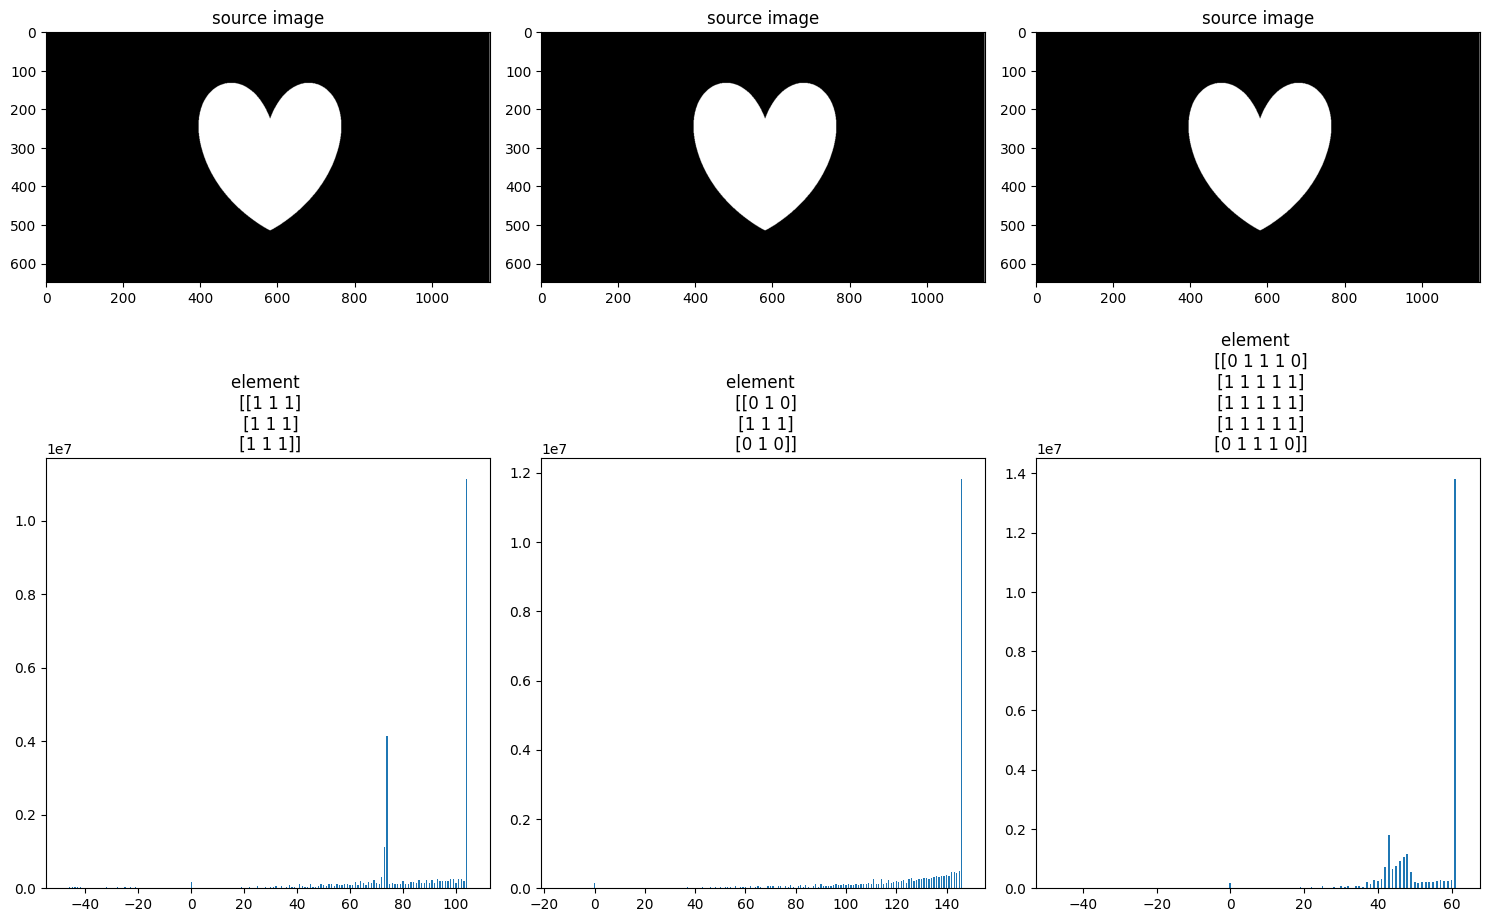

In [ ]:
image = cv2.imread('heart.png', cv2.IMREAD_GRAYSCALE)
show_result_binary(image)

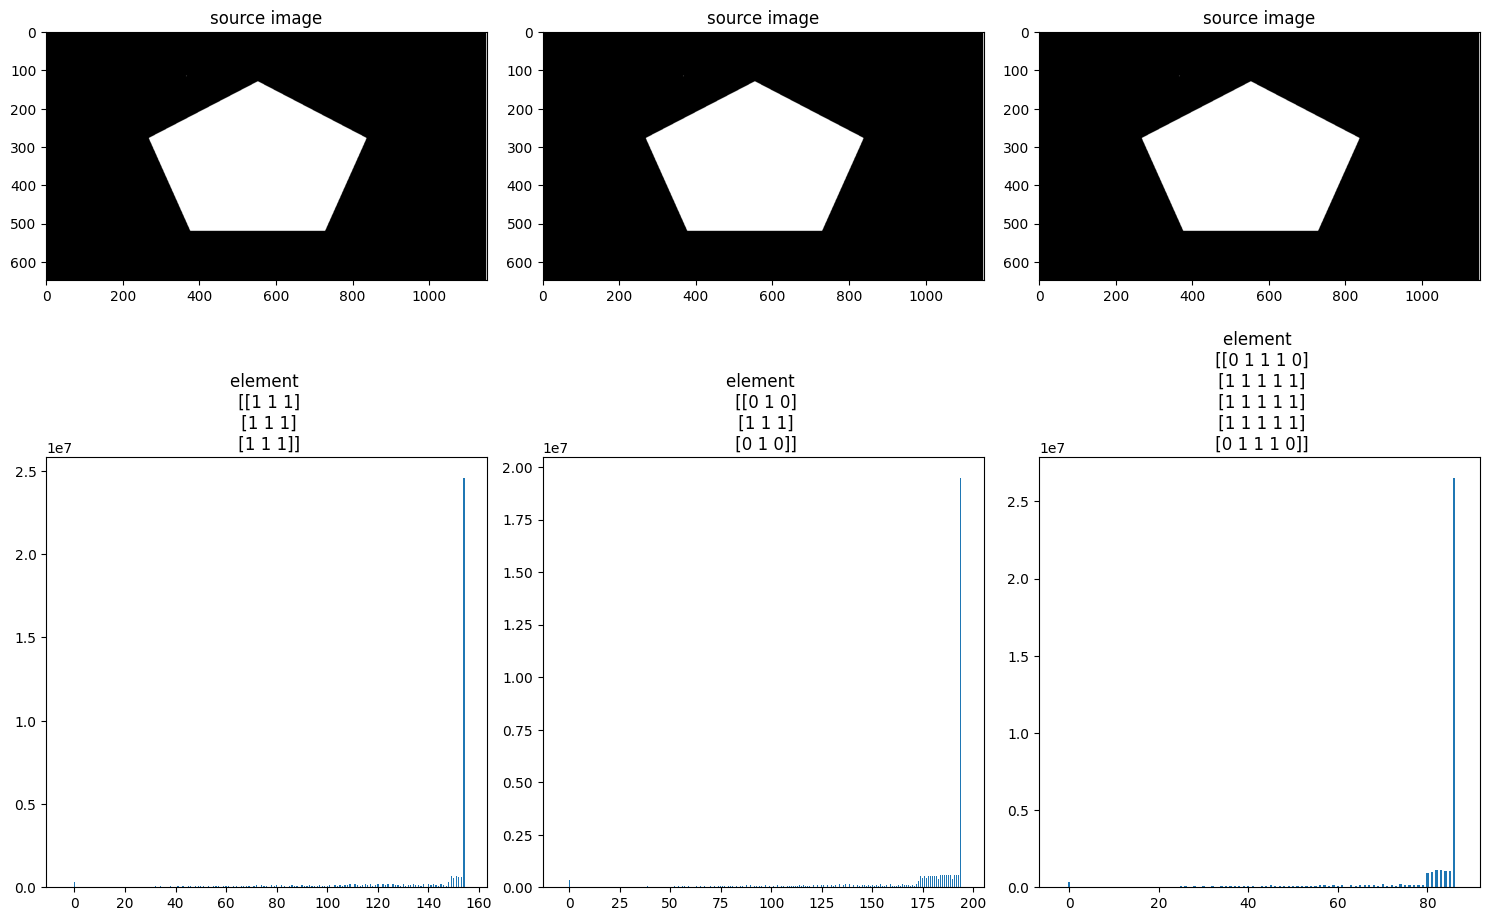

In [ ]:
image = cv2.imread('image3.png', cv2.IMREAD_GRAYSCALE)
show_result_binary(image)

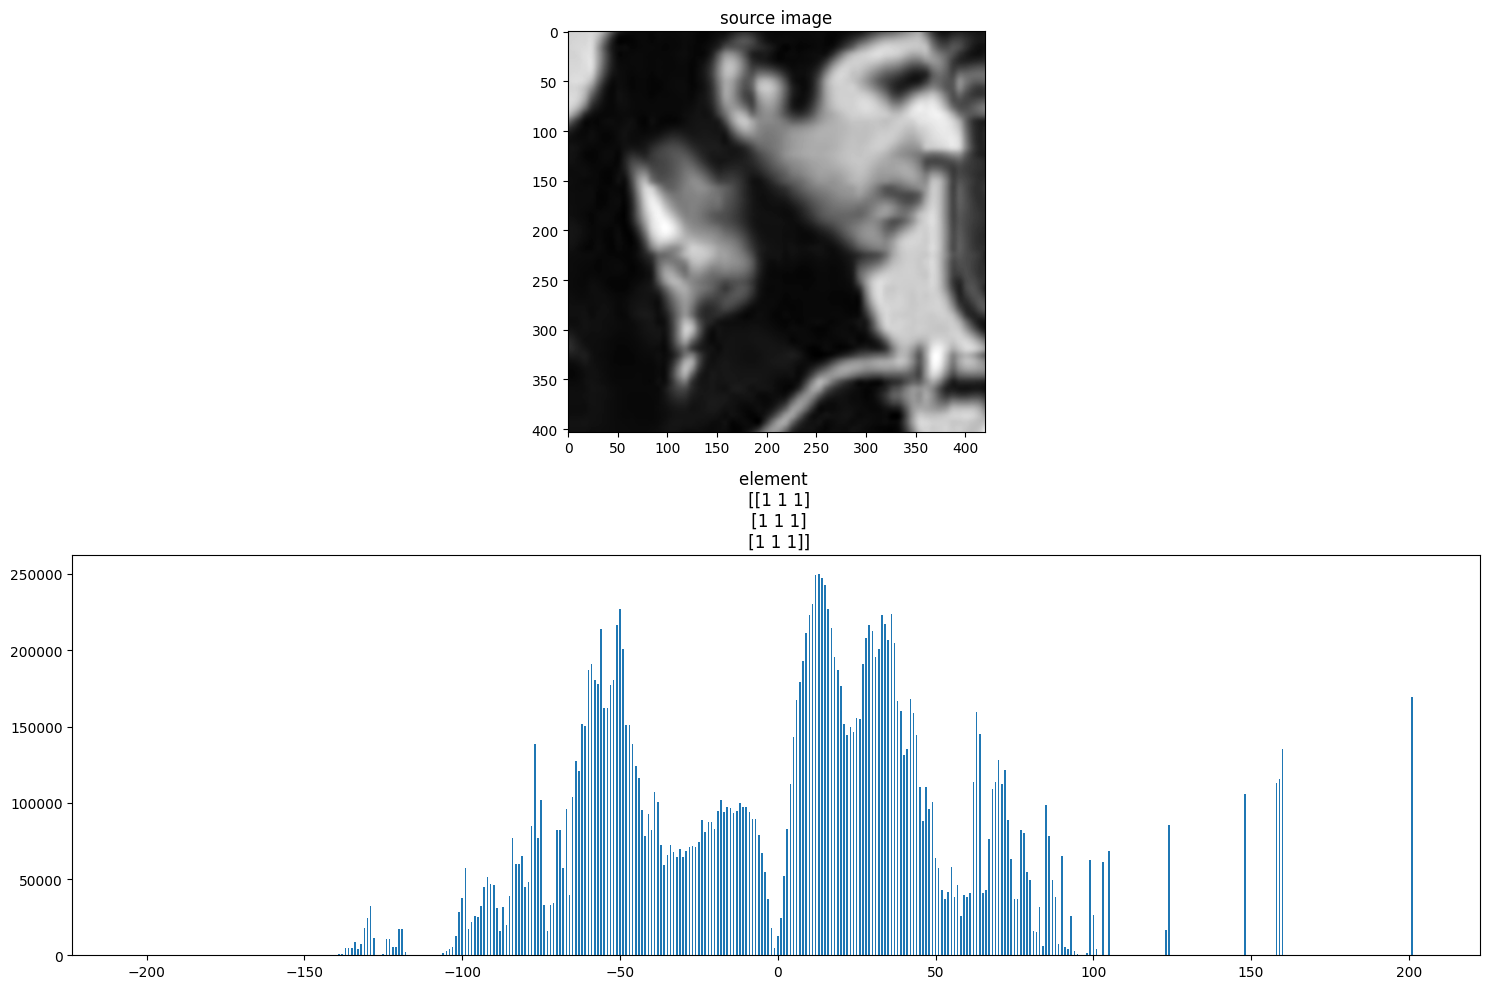

In [14]:
img = cv2.imread('halftone.png', cv2.IMREAD_GRAYSCALE)
f, axarr = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axarr[0].imshow(img, cmap='gray')
axarr[0].set_title('source image')
spectrum = get_spectrum_halftone(img, B1)
axarr[1].bar(spectrum.keys(), spectrum.values(), width=0.5)
axarr[1].set_title(f'element \n {B1}')
plt.tight_layout()
plt.show()